# Classification Modeling

####Stratified K-Fold (n = 5)
* In 5-fold cross-validation, the data is split into five equal-sized folds.
* Each iteration uses 80% of the data for training and 20% for validation, rotating the test set each time.
* The “stratified” aspect ensures that each fold maintains the same class distribution as the full dataset.

In [1]:
import pandas as pd

# Load clean data
df = pd.read_csv("/content/ACSPUMS1Y2022_Georgia_Data.csv")

# View a sample of five rows from the dataset
df.sample(5)

,TEN,RAC1P,CIT,SCHL,BLD,HUPAC,COW,MAR,SEX,VEH,WKL,AGEP,WAGP,NPF,GRPIP,WKHP,ST
29268,1,1,1,18,2,3,6,1,2,2,1,36,0,5,0,40,13
22231,2,1,1,21,2,4,1,5,2,1,1,34,30000,1,0,35,13
24854,2,1,1,11,2,2,0,5,2,3,0,15,0,5,0,0,13
75198,1,9,4,20,2,2,7,1,1,5,1,47,250000,4,0,45,13
99525,1,1,1,21,2,4,6,1,2,3,1,66,0,2,0,8,13


In [2]:
import pandas as pd
import numpy as np

def preprocess_data(df):
    # ============================
    # 1. Define Mapping Dictionaries
    # ============================

    marital_status_map = {
        1: "Married", 2: "Widowed", 3: "Divorced", 4: "Separated", 5: "Never married"
    }

    citizenship_map = {
        1: "Born in US", 2: "Born in Territory", 3: "Born abroad to US parents",
        4: "Naturalized", 5: "Not a citizen"
    }

    class_of_worker_map = {
        0: "Not Applicable", 1: "Private for-profit", 2: "Private nonprofit",
        3: "Local government", 4: "State government", 5: "Self-employed"
    }

    sex_map = {1: "Male", 2: "Female"}

    education_map = {
        0: "N/A", 1: "No schooling", 2: "Pre-K to Grade 4", 3: "Pre-K to Grade 4",
        4: "Pre-K to Grade 4", 5: "Pre-K to Grade 4", 6: "Grade 5-8", 7: "Grade 5-8",
        8: "Grade 5-8", 9: "Grade 5-8", 10: "Grade 9-12 (no diploma)",
        11: "Grade 9-12 (no diploma)", 12: "Grade 9-12 (no diploma)",
        13: "Grade 9-12 (no diploma)", 14: "Grade 9-12 (no diploma)",
        15: "Grade 9-12 (no diploma)", 16: "High School Graduate",
        17: "High School Graduate", 18: "Some College", 19: "Some College",
        20: "Associate's", 21: "Bachelor's", 22: "Graduate Degree", 23: "Graduate Degree"
    }

    race_map = {
        1: "White", 2: "Black", 3: "American Indian", 4: "Alaska Native",
        5: "Tribes Specified", 6: "Asian", 7: "Pacific Islander", 8: "Other", 9: "Two or More Races"
    }

    tenure_map = {
        0: "N/A", 1: "Owned with mortgage or loan (include home equity loans)",
        2: "Owned Free And Clear", 3: "Rented", 4: "Occupied without payment of rent"
    }

    building_map = {
        0: "N/A", 1: "Mobile Home or Trailer", 2: "One-family house detached",
        3: "One-family house attached", 4: "2 Apartments", 5: "3-4 Apartments",
        6: "5-9 Apartments", 7: "10-19 Apartments", 8: "20-49 Apartments",
        9: "50 or More Apartments", 10: "Boat, RV, van, etc."
    }

    children_map = {
        0: "N/A", 1: "With children under 6 years only", 2: "With children 6 to 17 years only",
        3: "With children under 6 years and 6 to 17 years", 4: "No children"
    }

    vehicle_map = {
        -1: "N/A", 0: "No vehicles", 1: "1 vehicle", 2: "2 vehicles",
        3: "3 vehicles", 4: "4 vehicles", 5: "5 vehicles", 6: "6 or more vehicles"
    }

    # ============================
    # 2. Apply the Mapping
    # ============================

    df["MAR"] = df["MAR"].map(marital_status_map)
    df["CIT"] = df["CIT"].map(citizenship_map)
    df["COW"] = df["COW"].map(class_of_worker_map)
    df["SEX"] = df["SEX"].map(sex_map)
    df["SCHL"] = df["SCHL"].map(education_map)
    df["RAC1P"] = df["RAC1P"].map(race_map)
    df["TEN"] = df["TEN"].map(tenure_map)
    df["BLD"] = df["BLD"].map(building_map)
    df["HUPAC"] = df["HUPAC"].map(children_map)
    df["VEH"] = df["VEH"].map(vehicle_map)

    # ============================
    # 3. Create income label
    # ============================
    df["income"] = np.where(df["WAGP"] > 50000, ">50K", "<=50K")

    # ============================
    # 4. Filter records
    # ============================
    df_filtered = df[
        (df["AGEP"] >= 16) &
        (df["WKHP"] > 0) &
        (df["COW"].notna()) &
        (df["WAGP"] > 0) &
        (df["AGEP"].notna()) &
        (df["WKHP"].notna()) &
        (df["SEX"].notna()) &
        (df["RAC1P"].notna())
    ].copy()

    # ============================
    # 5. Impute missing values
    # ============================

    # Create WAGP_BIN for group-based imputation
    df_filtered["WAGP_BIN"] = pd.qcut(df_filtered["WAGP"], q=4, duplicates="drop")

    # Impute categorical (object) columns
    object_cols = df_filtered.select_dtypes(include='object').columns.tolist()
    for col in object_cols:
        df_filtered[col] = df_filtered.groupby(
            ["COW", "WAGP_BIN", "RAC1P", "SEX"]
        )[col].transform(
            lambda x: x.fillna(x.mode()[0]) if not x.mode().empty else x.fillna("Unknown")
        )

    # Impute numeric columns using group-wise median
    numeric_cols = df_filtered.select_dtypes(include=np.number).columns.tolist()
    for col in numeric_cols:
        df_filtered[col] = df_filtered.groupby(["COW", "WAGP_BIN", "RAC1P", "SEX"])[col].transform(
            lambda x: x.fillna(x.median()) if x.notnull().any() else x.fillna(0)
        )


    # Drop helper columns
    df_filtered.drop(columns=["WAGP_BIN", "WAGP", "ST"], errors='ignore', inplace=True)

    return df_filtered


In [3]:
df_clean = preprocess_data(df)

/tmp/ipython-input-2-1563466324.py:107: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_filtered[col] = df_filtered.groupby(
/tmp/ipython-input-2-1563466324.py:107: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_filtered[col] = df_filtered.groupby(
/tmp/ipython-input-2-1563466324.py:107: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_filtered[col] = df_filtered.groupby(
/tmp/ipython-input-2-1563466324.py:107: Future

In [4]:
unmapped_rows = df[df["MAR"].isnull()]
if len(unmapped_rows) > 0:
    print(f"⚠️ Warning: {len(unmapped_rows)} rows did not map correctly in 'MAR'")

In [5]:
df_clean.sample(5)

,TEN,RAC1P,CIT,SCHL,BLD,HUPAC,COW,MAR,SEX,VEH,WKL,AGEP,NPF,GRPIP,WKHP,income
98767,Owned with mortgage or loan (include home equi...,White,Born in US,Graduate Degree,One-family house detached,No children,Self-employed,Married,Female,3 vehicles,1,54,2,0,40,>50K
101712,Owned with mortgage or loan (include home equi...,Two or More Races,Naturalized,Bachelor's,One-family house attached,With children 6 to 17 years only,Private for-profit,Divorced,Male,1 vehicle,1,44,4,0,40,>50K
37109,Owned Free And Clear,White,Born in US,High School Graduate,One-family house attached,No children,Private for-profit,Never married,Male,3 vehicles,1,18,3,0,20,<=50K
105703,Occupied without payment of rent,Black,Born in US,Grade 9-12 (no diploma),Mobile Home or Trailer,No children,Private for-profit,Never married,Male,3 vehicles,1,29,4,0,50,<=50K
8565,Owned with mortgage or loan (include home equi...,Black,Born in US,Graduate Degree,One-family house detached,No children,Local government,Married,Male,3 vehicles,1,52,5,0,40,<=50K


In [6]:
#@title Modeling with Grid Search & K-Fold Cross Validation Using Smote to handle class imbalance
# smote_modeling.py

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
import joblib


# # Sanitize column names for compatibility with XGBoost
# df_encoded.columns = df_encoded.columns.str.replace('[<>\[\](){}]', '', regex=True).str.replace(' ', '_')

# Encode categorical features
df_encoded = pd.get_dummies(df_clean, drop_first=True).astype(int)

# Split into features and target
X = df_encoded.drop(['income_>50K'], axis=1)
y = df_encoded['income_>50K']




# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Set up Stratified K-Fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --------------------------
# Logistic Regression
# --------------------------
logreg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(class_weight='balanced', max_iter=2000))])
logreg_params = {'clf__C': [0.1, 1, 10]}

logreg_grid = GridSearchCV(
    estimator=logreg_pipeline,
    param_grid=logreg_params,
    cv=skf,
    scoring='accuracy',
    n_jobs=-1
)
logreg_grid.fit(X_resampled, y_resampled)
print("\n✅ Logistic Regression")
print("Best Accuracy:", logreg_grid.best_score_)
print("Best Params:", logreg_grid.best_params_)

# --------------------------
# Random Forest
# --------------------------
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_params = {
    'n_estimators': [200, 250, 300],
    'max_depth': [None, 10, 20, 30]
}

rf_grid = GridSearchCV(
    estimator=rf,
    param_grid=rf_params,
    cv=skf,
    scoring='accuracy',
    n_jobs=-1
)
rf_grid.fit(X_resampled, y_resampled)
print("\n🌲 Random Forest")
print("Best Accuracy:", rf_grid.best_score_)
print("Best Params:", rf_grid.best_params_)

# --------------------------
# XGBoost
# --------------------------
xgb = XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)
xgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [6, 9]
}

xgb_grid = GridSearchCV(
    estimator=xgb,
    param_grid=xgb_params,
    cv=skf,
    scoring='accuracy',
    n_jobs=-1
)
xgb_grid.fit(X_resampled, y_resampled)
print("\n🚀 XGBoost")
print("Best Accuracy:", xgb_grid.best_score_)
print("Best Params:", xgb_grid.best_params_)



✅ Logistic Regression
Best Accuracy: 0.8165032190338138
Best Params: {'clf__C': 1}


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



🌲 Random Forest
Best Accuracy: 0.8306425393860497
Best Params: {'max_depth': 20, 'n_estimators': 250}


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:03:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



🚀 XGBoost
Best Accuracy: 0.833510180813098
Best Params: {'max_depth': 6, 'n_estimators': 200}


In [7]:
pd.set_option('display.max_columns', 100)
df_encoded.head()

,WKL,AGEP,NPF,GRPIP,WKHP,TEN_Occupied without payment of rent,TEN_Owned Free And Clear,TEN_Owned with mortgage or loan (include home equity loans),TEN_Rented,RAC1P_American Indian,RAC1P_Asian,RAC1P_Black,RAC1P_Other,RAC1P_Pacific Islander,RAC1P_Tribes Specified,RAC1P_Two or More Races,RAC1P_White,CIT_Born in Territory,CIT_Born in US,CIT_Naturalized,CIT_Not a citizen,SCHL_Bachelor's,SCHL_Grade 5-8,SCHL_Grade 9-12 (no diploma),SCHL_Graduate Degree,SCHL_High School Graduate,SCHL_No schooling,SCHL_Pre-K to Grade 4,SCHL_Some College,BLD_2 Apartments,BLD_20-49 Apartments,BLD_3-4 Apartments,BLD_5-9 Apartments,BLD_50 or More Apartments,"BLD_Boat, RV, van, etc.",BLD_Mobile Home or Trailer,BLD_N/A,BLD_One-family house attached,BLD_One-family house detached,HUPAC_No children,HUPAC_With children 6 to 17 years only,HUPAC_With children under 6 years and 6 to 17 years,HUPAC_With children under 6 years only,COW_Private for-profit,COW_Private nonprofit,COW_Self-employed,COW_State government,MAR_Married,MAR_Never married,MAR_Separated,MAR_Widowed,SEX_Male,VEH_2 vehicles,VEH_3 vehicles,VEH_4 vehicles,VEH_5 vehicles,VEH_6 or more vehicles,VEH_N/A,VEH_No vehicles,income_>50K
3,1,27,1,0,48,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0
6,1,19,1,0,50,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0
10,1,21,1,0,8,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0
17,1,25,1,0,45,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0
18,1,47,1,0,52,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0


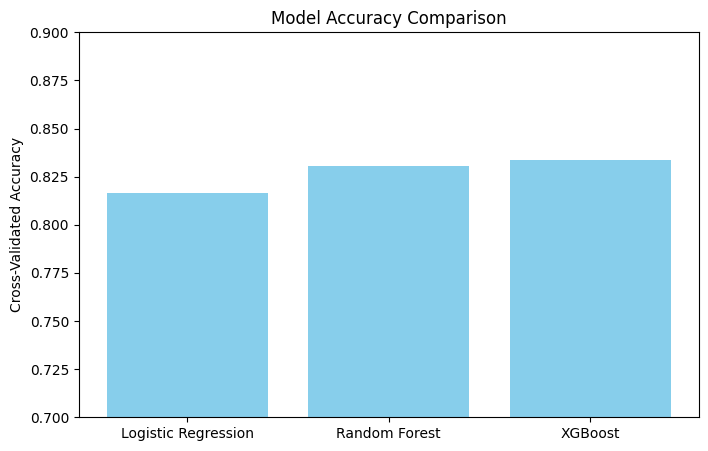

In [8]:
#@title Visual Comparison of Accuracy scores for the Different Models
import matplotlib.pyplot as plt
model_scores = {
    'Logistic Regression': logreg_grid.best_score_,
    'Random Forest': rf_grid.best_score_,
    'XGBoost': xgb_grid.best_score_
}

# Bar plot of model performance
plt.figure(figsize=(8, 5))
plt.bar(model_scores.keys(), model_scores.values(), color='skyblue')
plt.title('Model Accuracy Comparison')
plt.ylabel('Cross-Validated Accuracy')
plt.ylim(0.7, 0.9)
plt.show()

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:07:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


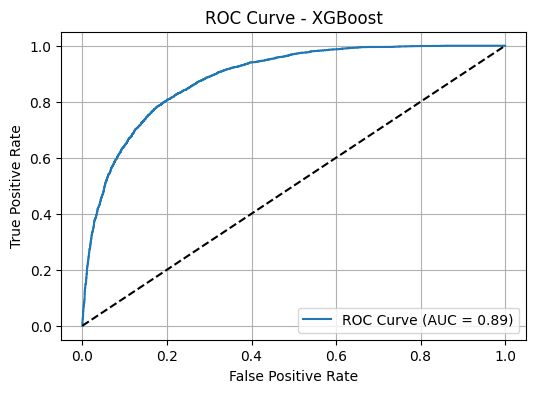

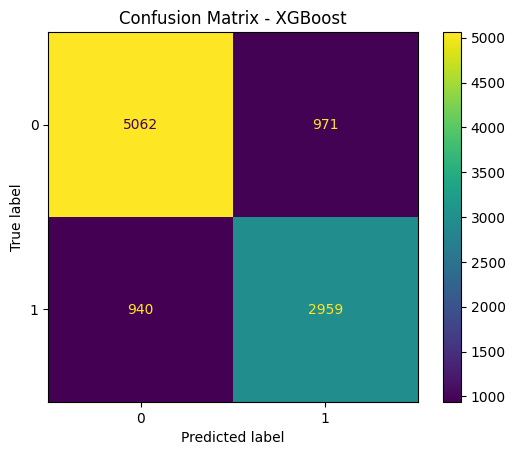

Classification Report - XGBoost
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      6033
           1       0.75      0.76      0.76      3899

    accuracy                           0.81      9932
   macro avg       0.80      0.80      0.80      9932
weighted avg       0.81      0.81      0.81      9932



In [13]:
#@title Accuracy Analysis for Best Fitting Model
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Evaluation for Best Model: Random Forest
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Best Model
best_model = xgb_grid.best_estimator_
# Drop 'fnlwgt', 'capital-gain', and 'capital-loss' from the features
X = X.drop(columns=['fnlwgt', 'capital-gain', 'capital-loss'], errors='ignore')

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Use the best model from grid search
# best_model = xgb_grid.best_estimator_
best_model.fit(X_train, y_train)

# Predict probabilities and labels
y_proba = best_model.predict_proba(X_test)[:, 1]
y_pred = best_model.predict(X_test)

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(roc_auc_score(y_test, y_proba)))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend()
plt.grid()
plt.show()

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)
plt.title('Confusion Matrix - XGBoost')
plt.show()

# Classification Report
print("Classification Report - XGBoost")
print(classification_report(y_test, y_pred))

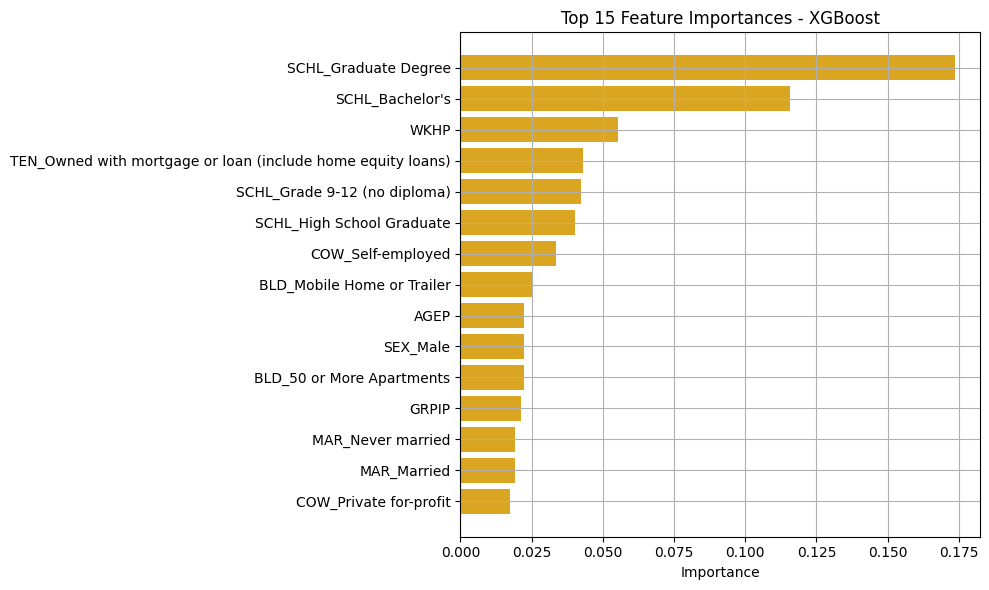

In [ ]:
# @title Feature Importance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Make sure you're referencing the best trained XGBoost model
xgb_model = xgb_grid.best_estimator_

# Get feature importances
importances = xgb_model.feature_importances_
feature_names = X.columns

# Create DataFrame of feature importances
feat_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort and select top 15
feat_df = feat_df.sort_values(by='Importance', ascending=False).head(15)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feat_df['Feature'], feat_df['Importance'], color='goldenrod')
plt.gca().invert_yaxis()
plt.title('Top 15 Feature Importances - XGBoost')
plt.xlabel('Importance')
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
#@title Save the best model
joblib.dump(xgb_grid.best_estimator_, "income_model.pkl")
joblib.dump(X.columns.tolist(), "model_features.pkl")

['model_features.pkl']

In [10]:
import joblib
feature_list = joblib.load("model_features.pkl")


In [11]:
def generate_payload(df_clean, feature_list, row_index=0):
    import json

    # Encode features like your pipeline
    encoded = pd.get_dummies(df_clean, drop_first=True).astype(int)

    # Get the selected row
    row_data = encoded.iloc[row_index]

    # Align columns to model input
    aligned = pd.DataFrame(columns=feature_list)
    aligned.loc[0] = 0  # initialize with zeros
    for col in row_data.index:
        if col in aligned.columns:
            aligned.at[0, col] = row_data[col]

    # Convert to dict
    payload_dict = aligned.iloc[0].to_dict()

    # Optional: write to file
    with open("test_payload.json", "w") as f:
        json.dump(payload_dict, f, indent=2)

    return payload_dict


In [12]:
payload = generate_payload(df_clean, feature_list, row_index=0)
print(payload)


{'WKL': 1, 'AGEP': 27, 'NPF': 1, 'GRPIP': 0, 'WKHP': 48, 'TEN_Occupied without payment of rent': 0, 'TEN_Owned Free And Clear': 0, 'TEN_Owned with mortgage or loan (include home equity loans)': 0, 'TEN_Rented': 0, 'RAC1P_American Indian': 0, 'RAC1P_Asian': 0, 'RAC1P_Black': 1, 'RAC1P_Other': 0, 'RAC1P_Pacific Islander': 0, 'RAC1P_Tribes Specified': 0, 'RAC1P_Two or More Races': 0, 'RAC1P_White': 0, 'CIT_Born in Territory': 0, 'CIT_Born in US': 1, 'CIT_Naturalized': 0, 'CIT_Not a citizen': 0, "SCHL_Bachelor's": 0, 'SCHL_Grade 5-8': 0, 'SCHL_Grade 9-12 (no diploma)': 0, 'SCHL_Graduate Degree': 0, 'SCHL_High School Graduate': 1, 'SCHL_No schooling': 0, 'SCHL_Pre-K to Grade 4': 0, 'SCHL_Some College': 0, 'BLD_2 Apartments': 0, 'BLD_20-49 Apartments': 0, 'BLD_3-4 Apartments': 0, 'BLD_5-9 Apartments': 0, 'BLD_50 or More Apartments': 0, 'BLD_Boat, RV, van, etc.': 0, 'BLD_Mobile Home or Trailer': 0, 'BLD_N/A': 1, 'BLD_One-family house attached': 0, 'BLD_One-family house detached': 0, 'HUPAC_No